# Measure Capacity of QNN architechture with Effective Dimension analysis

References:
- QISKIT guide to calculate ED: [Effective Dimension of Qiskit Neural Networks](https://qiskit.org/documentation/machine-learning/tutorials/10_effective_dimension.html)
- [The power of quantum neural networks](https://arxiv.org/pdf/2011.00027.pdf)
- [Effective dimension of machine learning models](https://arxiv.org/pdf/2112.04807.pdf)

In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.23.1', 'qiskit-aer': '0.11.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.0', 'qiskit': '0.41.0', 'qiskit-nature': '0.5.2', 'qiskit-finance': '0.3.4', 'qiskit-optimization': '0.5.0', 'qiskit-machine-learning': '0.5.0'}

The Fisher Information matrix reflects how sensitive a neural network's output to change in the network's parameter space.
Effective dimension uses Fisher Information matrix to measure capacity of NNs.

Steps as follows:
- Define a neural network
- Define a series of inputs and weight samples.
- Use `EffectiveDimension` class to calculate effective dimension


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists
from os import makedirs

from qiskit import Aer, IBMQ
from qiskit.utils import QuantumInstance
from qiskit.utils import algorithm_globals
from qiskit.algorithms.optimizers import COBYLA, NELDER_MEAD, SLSQP, SPSA
from qiskit.opflow import Z, X, I, StateFn, PauliExpectation, Gradient, PauliSumOp
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN, OpflowQNN
from qiskit_machine_learning.neural_networks import EffectiveDimension
from qiskit_machine_learning.algorithms.classifiers import VQC, NeuralNetworkClassifier
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension
from qiskit.primitives import Estimator # Statevector estimator

from Components.circuits import preTrainedBlockGenerator, layerwise_training, featureMapGenerator, AnsatzGenerator
from Components.data import iris, fetch_mnist_balanced
from Components.utils import plot_loss, score, parity, classification_callback, plot_objfn_range, result_to_objfun_dataframes, save_results
from Components.train import create_qnn, sampling_experiment

from qiskit.providers.fake_provider import FakeVigo, FakePerth

import pandas as pd

import time

from IPython.display import clear_output

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [3]:
from Components.log_ops import plot_method_data
from Components.log_ops import logs_to_methods_data

## Settings for experiment

In [4]:
SAMPLING_DATA_SIZE = 100
FEATURE_DIM = 4
max_qubit = FEATURE_DIM
MAX_REPS = 9
MIN_REPS = 1
MAX_IDENTITIES_BLOCKS = 2
ENTANGLEMENT = 'linear'

MAX_ITER = 120
MAX_INST = 10
ITER_STEP = 25
GLOBAL_INPUT_SAMPLES = 20
GLOBAL_WEIGHT_SAMPLES = 20
GLOBAL_OPERATOR = PauliSumOp.from_list([('Z'*FEATURE_DIM, 1)])
LOCAL_OPERATOR = PauliSumOp.from_list([('I' * (FEATURE_DIM - 2)+'Z'*2, 1)])


# define ranges to test different numbers of data
n = [75, 90, 105, 120, 135, 150, 200, 300, 400, 1000, 5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

# use user defined data
# iris_df = iris(pd=True).drop(columns='target')
mnist_df = fetch_mnist_balanced(PCA_n = FEATURE_DIM, data_size=SAMPLING_DATA_SIZE, split=False)[0]
input_samples = mnist_df

### Select a data set and its folder
LOGS_PATH = './Logs-MNIST-v4'

/home/jacob/miniconda3/envs/qiskit/lib/python3.8/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Data set: 100 samples
No train/test splitting
Number of features: 785
Classes: [-1  1]


In [5]:
# trained weights
_, weights, _, _ = logs_to_methods_data(LOGS_PATH)

print(f'\n\nMethods found: {", ".join(list(weights.keys()))}\n')

List of a valid archive: ./Logs-MNIST-v4
   Found method: m0
      Found method instance: m0-0
         ... Instance m0-0 renumbered as 0
      Found method instance: m0-1
         ... Instance m0-1 renumbered as 1
      Found method instance: m0-2
         ... Instance m0-2 renumbered as 2
      Found method instance: m0-3
         ... Instance m0-3 renumbered as 3
      Found method instance: m0-4
         ... Instance m0-4 renumbered as 4
      Found method instance: m0-5
         ... Instance m0-5 renumbered as 5
      Found method instance: m0-6
         ... Instance m0-6 renumbered as 6
      Found method instance: m0-7
         ... Instance m0-7 renumbered as 7
      Found method instance: m0-8
         ... Instance m0-8 renumbered as 8
      Found method instance: m0-9
         ... Instance m0-9 renumbered as 9
      Method m0 had 10 valid, 0 missing, and 0 in error instances
   Found method: m1
      Found method instance: m1-0
         ... Instance m1-0 renumbered as 0
      

In [6]:
# Global effective dimension

def get_global_ed(qnn):
    # weight_samples = algorithm_globals.random.uniform(0, 1, size=(10, qnn.num_weights))

    global_ed = EffectiveDimension(
        qnn=qnn, 
        weight_samples=GLOBAL_WEIGHT_SAMPLES, 
        input_samples=GLOBAL_INPUT_SAMPLES
        )
        
    return global_ed

def get_local_ed_loop(qnn, weight_samples, input_samples, dataset_size, step_size=25):
    local_ed_list = []
    for i in range(0, len(weight_samples), step_size):
        local_ed = LocalEffectiveDimension(
            qnn=qnn, 
            weight_samples=weight_samples.iloc[i], 
            input_samples=input_samples
        )
        local_eff_dim = local_ed.get_effective_dimension(dataset_size=dataset_size)
        local_ed_list.append(local_eff_dim)
        print(f'Iteration: {i}; Local E-D: {local_eff_dim}\n')

    return local_ed_list

def get_local_ed_loop_v1(qnn, weight_samples, input_samples, dataset_size, step_size=25):
    local_ed_list = []
    for i in range(0, len(weight_samples), step_size):
        local_ed = LocalEffectiveDimension(
            qnn=qnn, 
            weight_samples=weight_samples.iloc[i], 
            input_samples=input_samples
        )
        local_eff_dim = local_ed.get_effective_dimension(dataset_size=dataset_size)
        local_ed_list.append(local_eff_dim)
        print(f'Iteration: {i}; Local E-D: {local_eff_dim}\n')

    return local_ed_list

In [7]:
# Return the number of perameters per weights recording
def weights_no(weights):
    return len(weights[0].columns)

# Calculate global effective dimension
def calc_global_ed(features, reps, ops, n):
    feature_map = featureMapGenerator(features)
    ansatz = AnsatzGenerator(features, reps=reps)
    qc = feature_map.compose(ansatz)

    qnn = EstimatorQNN(
        circuit=qc,
        observables=ops,
        input_params=list(feature_map.parameters),
        weight_params=list(ansatz.parameters)
    )
    
    global_ed = get_global_ed(qnn=qnn)
    global_eff = global_ed.get_effective_dimension(dataset_size=n)
    
    return global_eff

# Calculate lolcal effective dimension
def calc_local_ed(features, reps, ops, n, weights, input_samples, feature_map=None, ansatz=None):
    if(feature_map == None): feature_map = featureMapGenerator(features)
    if(ansatz == None): ansatz = AnsatzGenerator(features, reps=reps)
    qc = feature_map.compose(ansatz)

    qnn = EstimatorQNN(
        circuit=qc,
        estimator=Estimator(),
        observables=ops,
        input_params=list(feature_map.parameters),
        weight_params=list(ansatz.parameters)
    )
    
    local_eff = []
    for i in range(len(weights)):
        print(f'Weight sample {len(local_eff)}')
        local_eff_inst = get_local_ed_loop(qnn, weights[i], input_samples, n, step_size=ITER_STEP)
        local_eff.append(local_eff_inst)
        clear_output(wait=True)
        
    return local_eff

In [8]:
def ed_plot(method, method_name, d, iter_step):
    fig, axs = plt.subplots(2)
    fig.set_figheight(11)
    fig.set_figwidth(8)
    fig.tight_layout(h_pad=4)
    fig.subplots_adjust(top=0.9)
    fig.suptitle(f'Effective Dimension / {method} - {method_name}', y=0.95)

    axs[0].set_title(f'Method "{method}", d={d}')
    axs[0].set_xlabel("Number of data")
    axs[0].set_ylabel("Normalised GLOBAL Effective dimension")
    axs[0].plot(n, np.array(global_eff) / d)
    axs[0].semilogx()

    axs[1].set_title(f'Method "{method}", d={d}')
    axs[1].set_xlabel("Number of data")
    axs[1].set_ylabel("Normalized LOCAL effective dimension")
    for i in range(len(local_eff[0])):
        axs[1].plot(n, np.array(local_eff[0][i]) / d)
    axs[1].legend([f"iter# {i*iter_step}" for i in range(len(local_eff[0]))])
         # loc='lower center', bbox_to_anchor=(0.5, -0.25),
         # ncol=3, fancybox=True, fontsize='small')

    axs[1].semilogx()
    plt.show()

## Method 0 Effective Dim (Generic - No BP Strategy)

In [9]:
method = 'm0'
method_name = 'Generic Without Any BP Strategy'
operator = GLOBAL_OPERATOR
reps = MAX_REPS
d = weights_no(weights[method])
inst_no = len(weights[method])
print(f'Method {method} - {method_name}:\n'+
      f'\tdim={d}, inst_no={inst_no}, reps={reps}, ops={str(operator.to_pauli_op())}')

Method m0 - Generic Without Any BP Strategy:
	dim=40, inst_no=10, reps=9, ops=ZZZZ


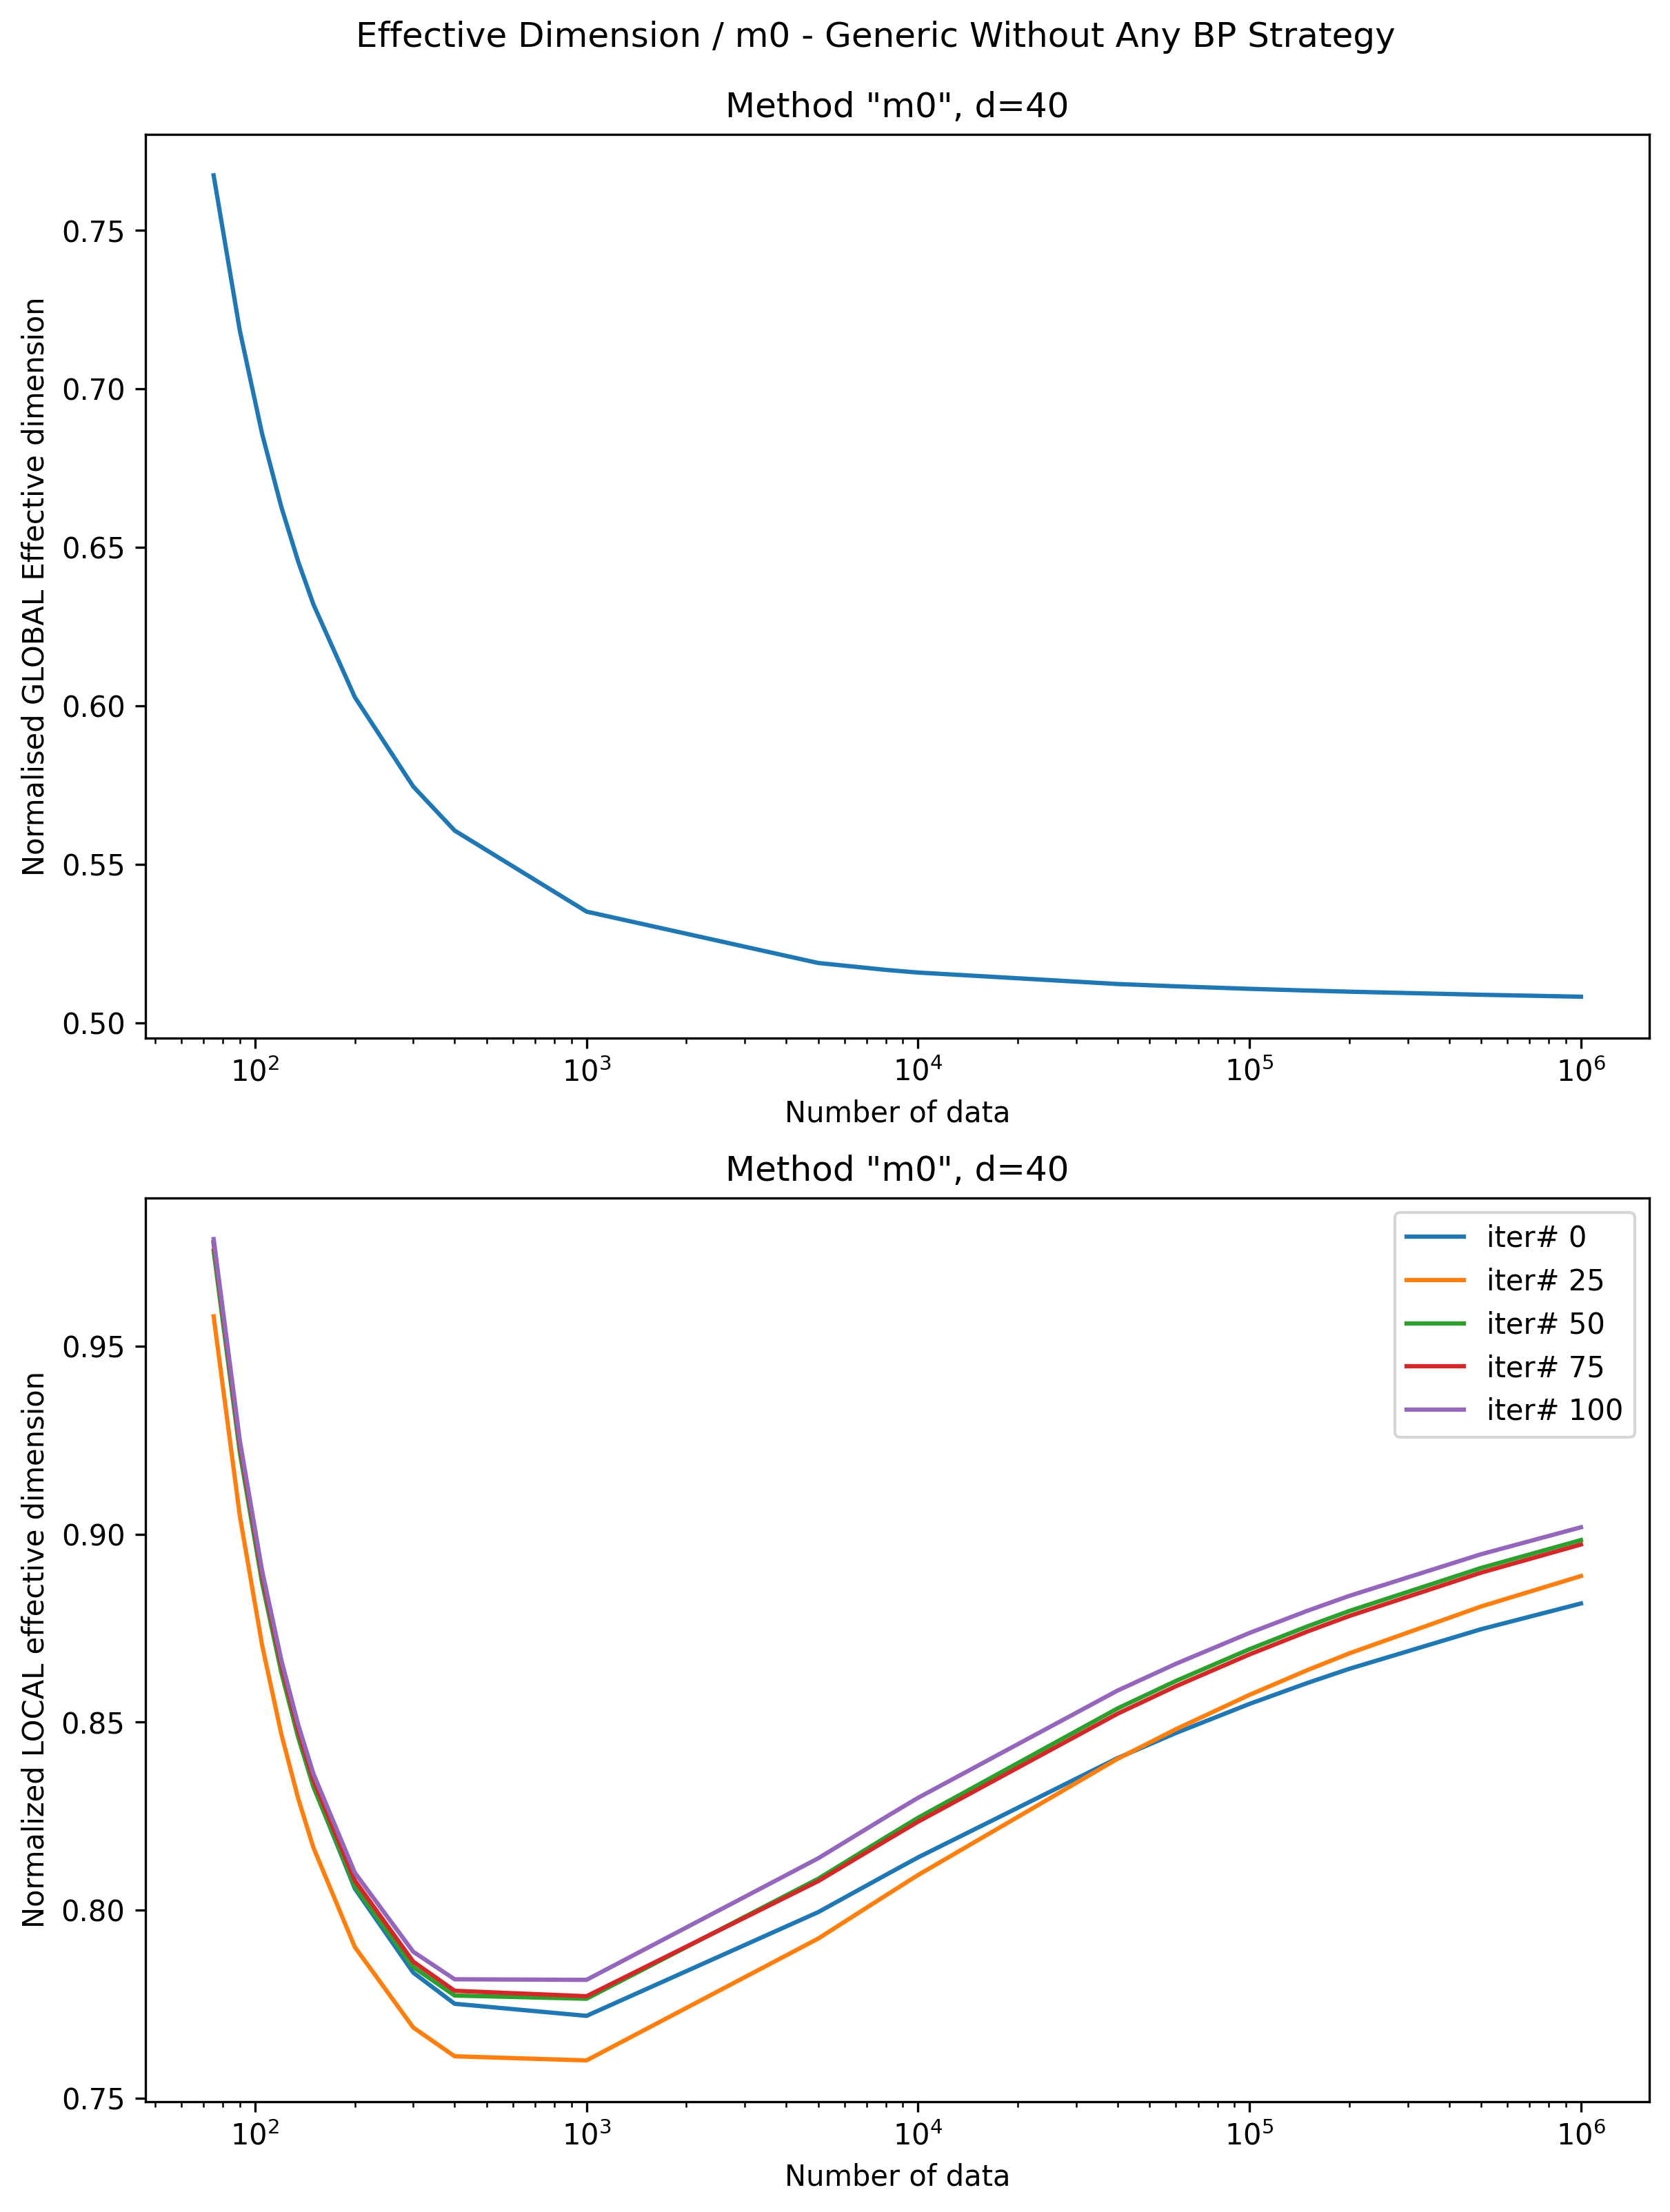

In [10]:
global_eff = calc_global_ed(FEATURE_DIM, reps, operator, n)
local_eff = calc_local_ed(FEATURE_DIM, reps, operator, n, 
                          weights[method], input_samples)
ed_plot(method, method_name, weights_no(weights[method]), ITER_STEP)

In [11]:
m = method
log_path = LOGS_PATH
df = pd.DataFrame(global_eff)

if (not exists(log_path)):
    print(f'Invalid archive: {log_path}')
else:
    if (not exists(f'{log_path}/{m}')):
        print(f'{" "*3}Missing method: {m}, creating the method')
        makedirs(f'{log_path}/{m}')
        
    df.to_csv(f'{log_path}/{m}/{m}-GlobalED.csv')
    for l in range(len(local_eff)):
        df = pd.DataFrame(local_eff[l])
        df.to_csv(f'{log_path}/{m}/{m}-{l}-LocalED.csv')

## Method 1 Effective Dim (Local Cost Function and Shallow Depth)

In [12]:
method = 'm1'
method_name = 'Local Cost Function and Shallow Depth'
operator = LOCAL_OPERATOR
reps = MIN_REPS
d = weights_no(weights[method])
inst_no = len(weights[method])
print(f'Method {method} - {method_name}:\n'+
      f'\tdim={d}, inst_no={inst_no}, reps={reps}, ops={str(operator.to_pauli_op())}')

Method m1 - Local Cost Function and Shallow Depth:
	dim=8, inst_no=10, reps=1, ops=IIZZ


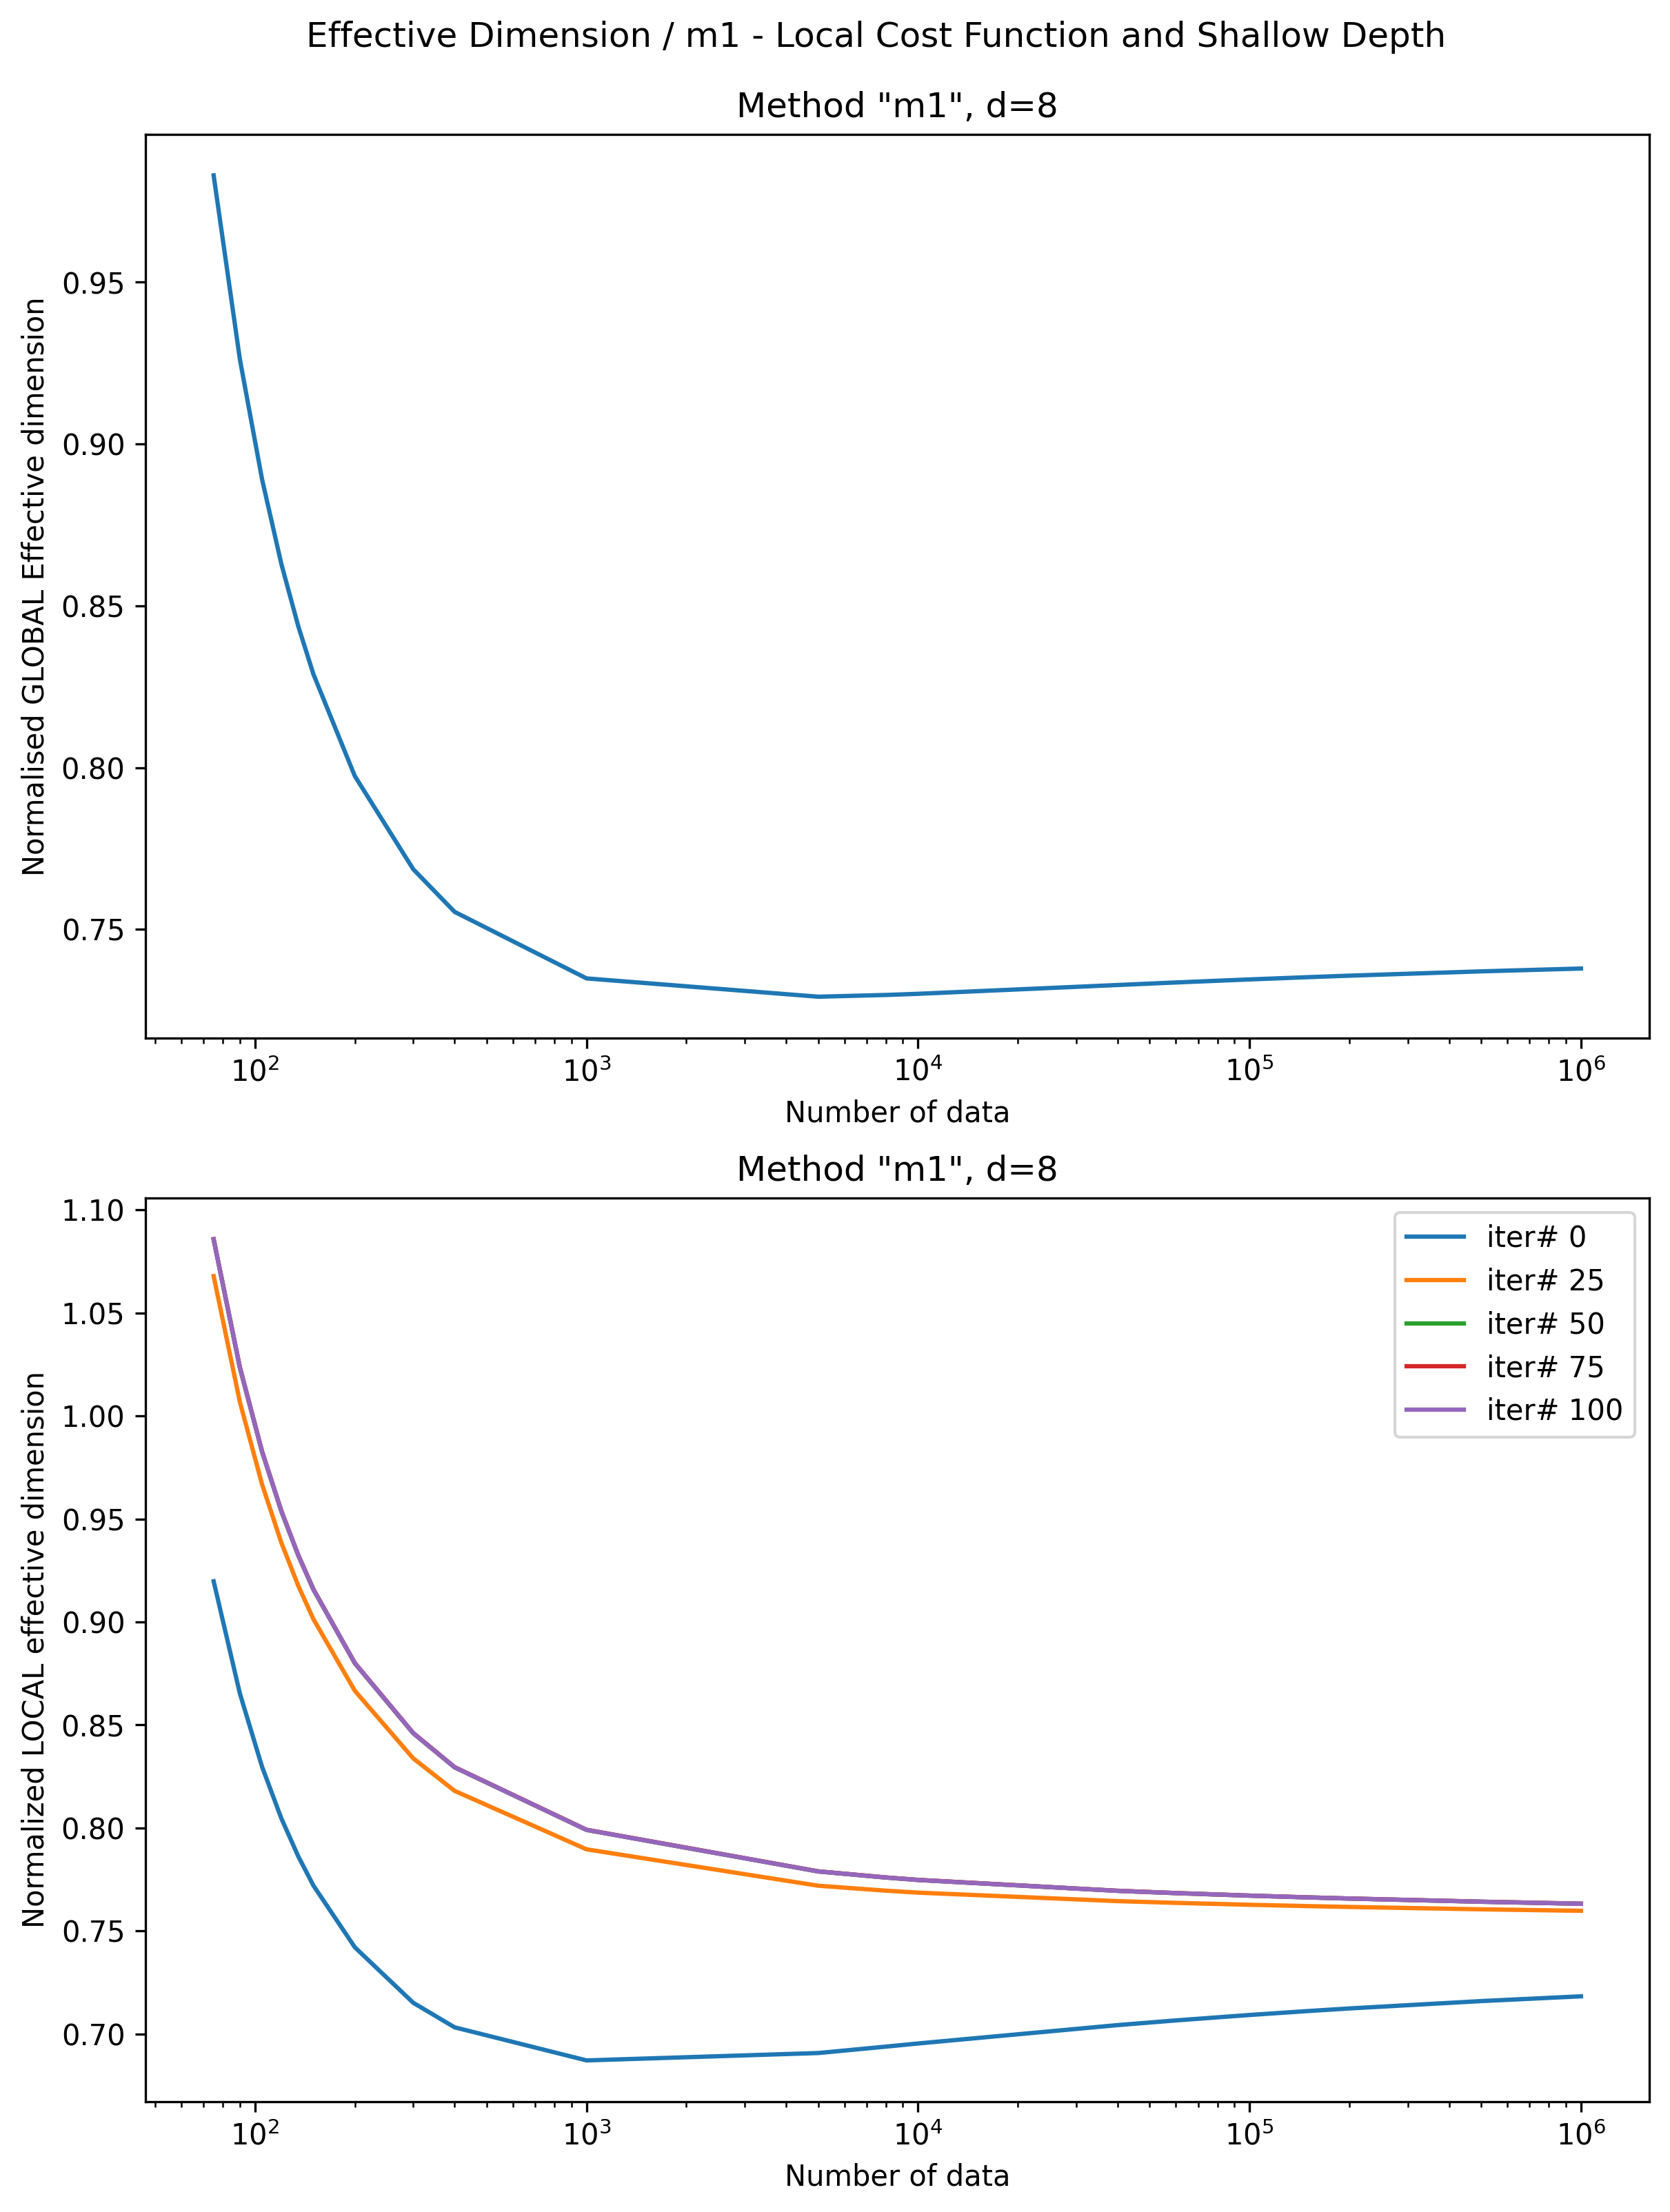

In [13]:
global_eff = calc_global_ed(FEATURE_DIM, reps, operator, n)
local_eff = calc_local_ed(FEATURE_DIM, reps, operator, n, 
                          weights[method], input_samples)
ed_plot(method, method_name, weights_no(weights[method]), ITER_STEP)

In [14]:
m = method
log_path = LOGS_PATH
df = pd.DataFrame(global_eff)

if (not exists(log_path)):
    print(f'Invalid archive: {log_path}')
else:
    print(f'Found a vvalid archive: {log_path}')
    if (not exists(f'{log_path}/{m}')):
        print(f'{" "*3}Missing method: {m}, creating the method')
        makedirs(f'{log_path}/{m}')
        
    print(f'{" "*3}Saving global effective dimension: {m}')
    df.to_csv(f'{log_path}/{m}/{m}-GlobalED.csv')
    print(f'{" "*3}Saving global effective dimension: {m} ({len(local_eff)} instances)')
    for l in range(len(local_eff)):
        df = pd.DataFrame(local_eff[l])
        df.to_csv(f'{log_path}/{m}/{m}-{l}-LocalED.csv')

Found a vvalid archive: ./Logs-MNIST-v4
   Saving global effective dimension: m1
   Saving global effective dimension: m1 (10 instances)


## Method 2 Effective Dim (Layerwise Learning)

In [15]:
method = 'm2'
method_name = 'Layerwise Learning'
operator = GLOBAL_OPERATOR
reps = MAX_REPS
d = weights_no(weights[method])
inst_no = len(weights[method])
print(f'Method {method} - {method_name}:\n'+
      f'\tdim={d}, inst_no={inst_no}, reps={reps}, ops={str(operator.to_pauli_op())}')

Method m2 - Layerwise Learning:
	dim=40, inst_no=10, reps=9, ops=ZZZZ


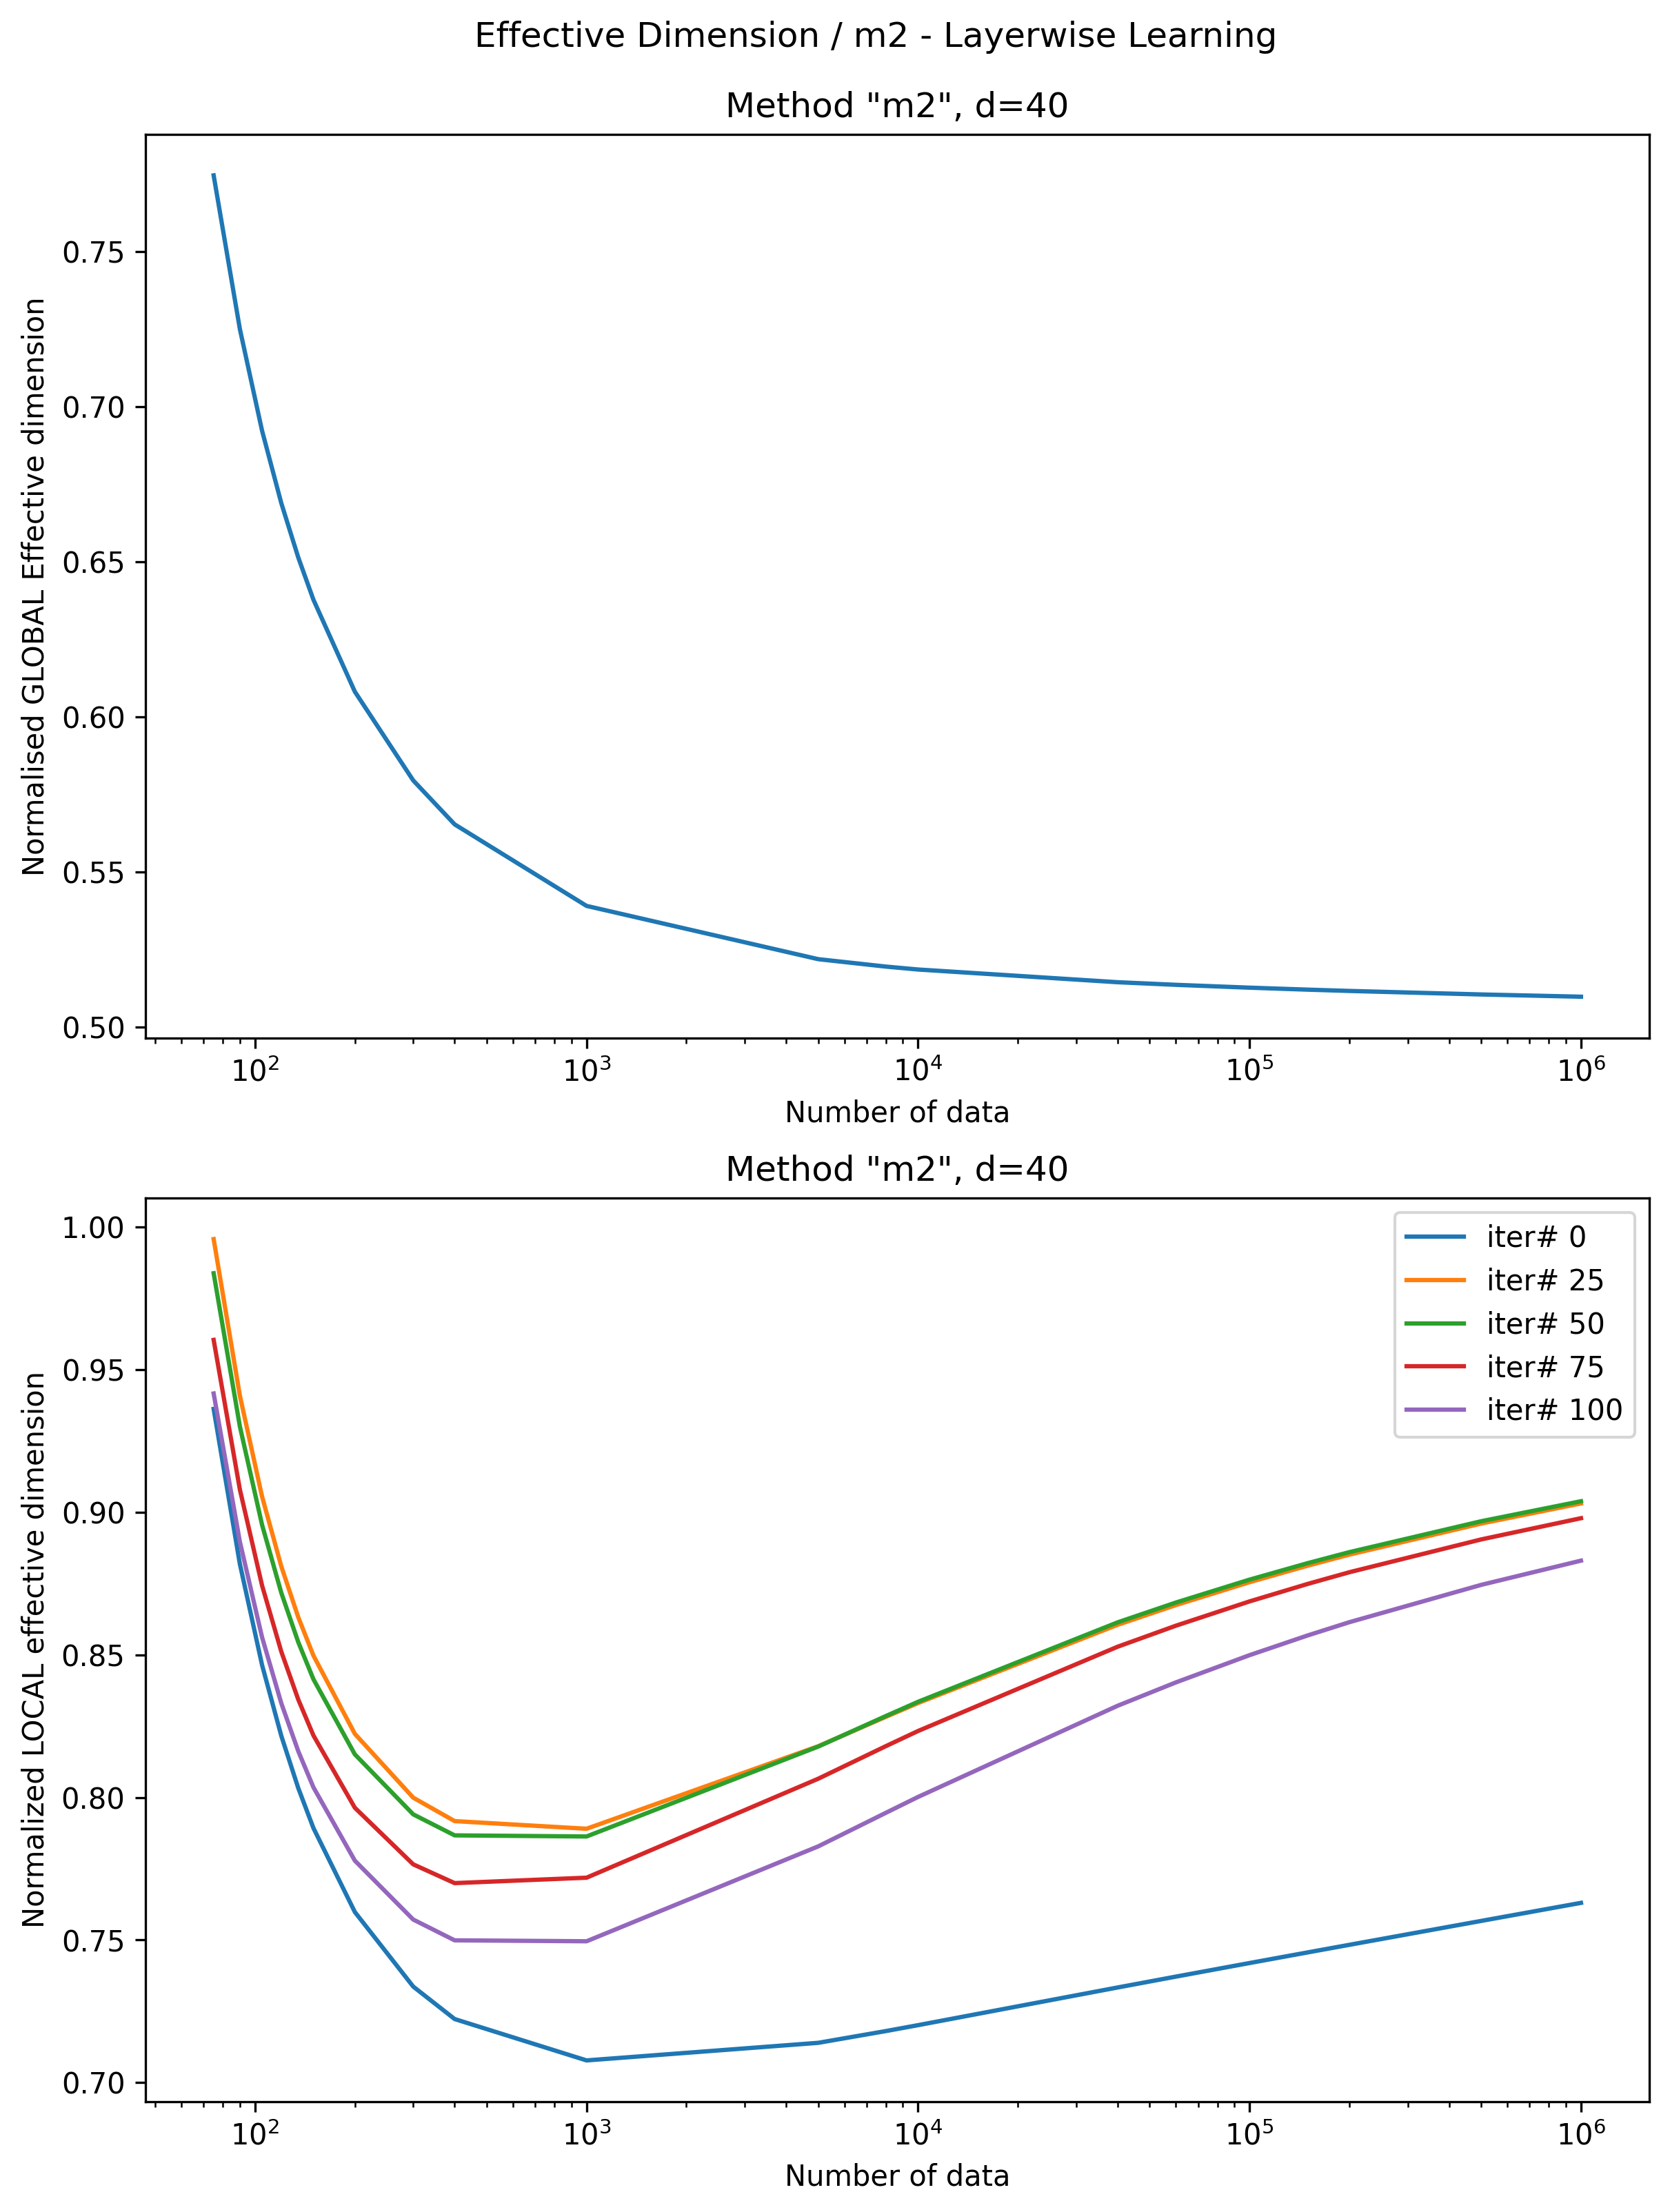

In [16]:
global_eff = calc_global_ed(FEATURE_DIM, reps, operator, n)
local_eff = calc_local_ed(FEATURE_DIM, reps, operator, n, 
                          weights[method], input_samples)
ed_plot(method, method_name, weights_no(weights[method]), ITER_STEP)

In [17]:
m = method
log_path = LOGS_PATH
df = pd.DataFrame(global_eff)

if (not exists(log_path)):
    print(f'Invalid archive: {log_path}')
else:
    if (not exists(f'{log_path}/{m}')):
        print(f'{" "*3}Missing method: {m}, creating the method')
        makedirs(f'{log_path}/{m}')
        
    df.to_csv(f'{log_path}/{m}/{m}-GlobalED.csv')
    for l in range(len(local_eff)):
        df = pd.DataFrame(local_eff[l])
        df.to_csv(f'{log_path}/{m}/{m}-{l}-LocalED.csv')

## Method 3 Effective Dim (Identity Blocks)

In [18]:
method = 'm3'
method_name = 'Identity Blocks'
operator = GLOBAL_OPERATOR
reps = MAX_REPS
d = weights_no(weights[method])
inst_no = len(weights[method])
print(f'Method {method} - {method_name}:\n'+
      f'\tdim={d}, inst_no={inst_no}, reps={reps}, ops={str(operator.to_pauli_op())}')

Method m3 - Identity Blocks:
	dim=40, inst_no=10, reps=9, ops=ZZZZ


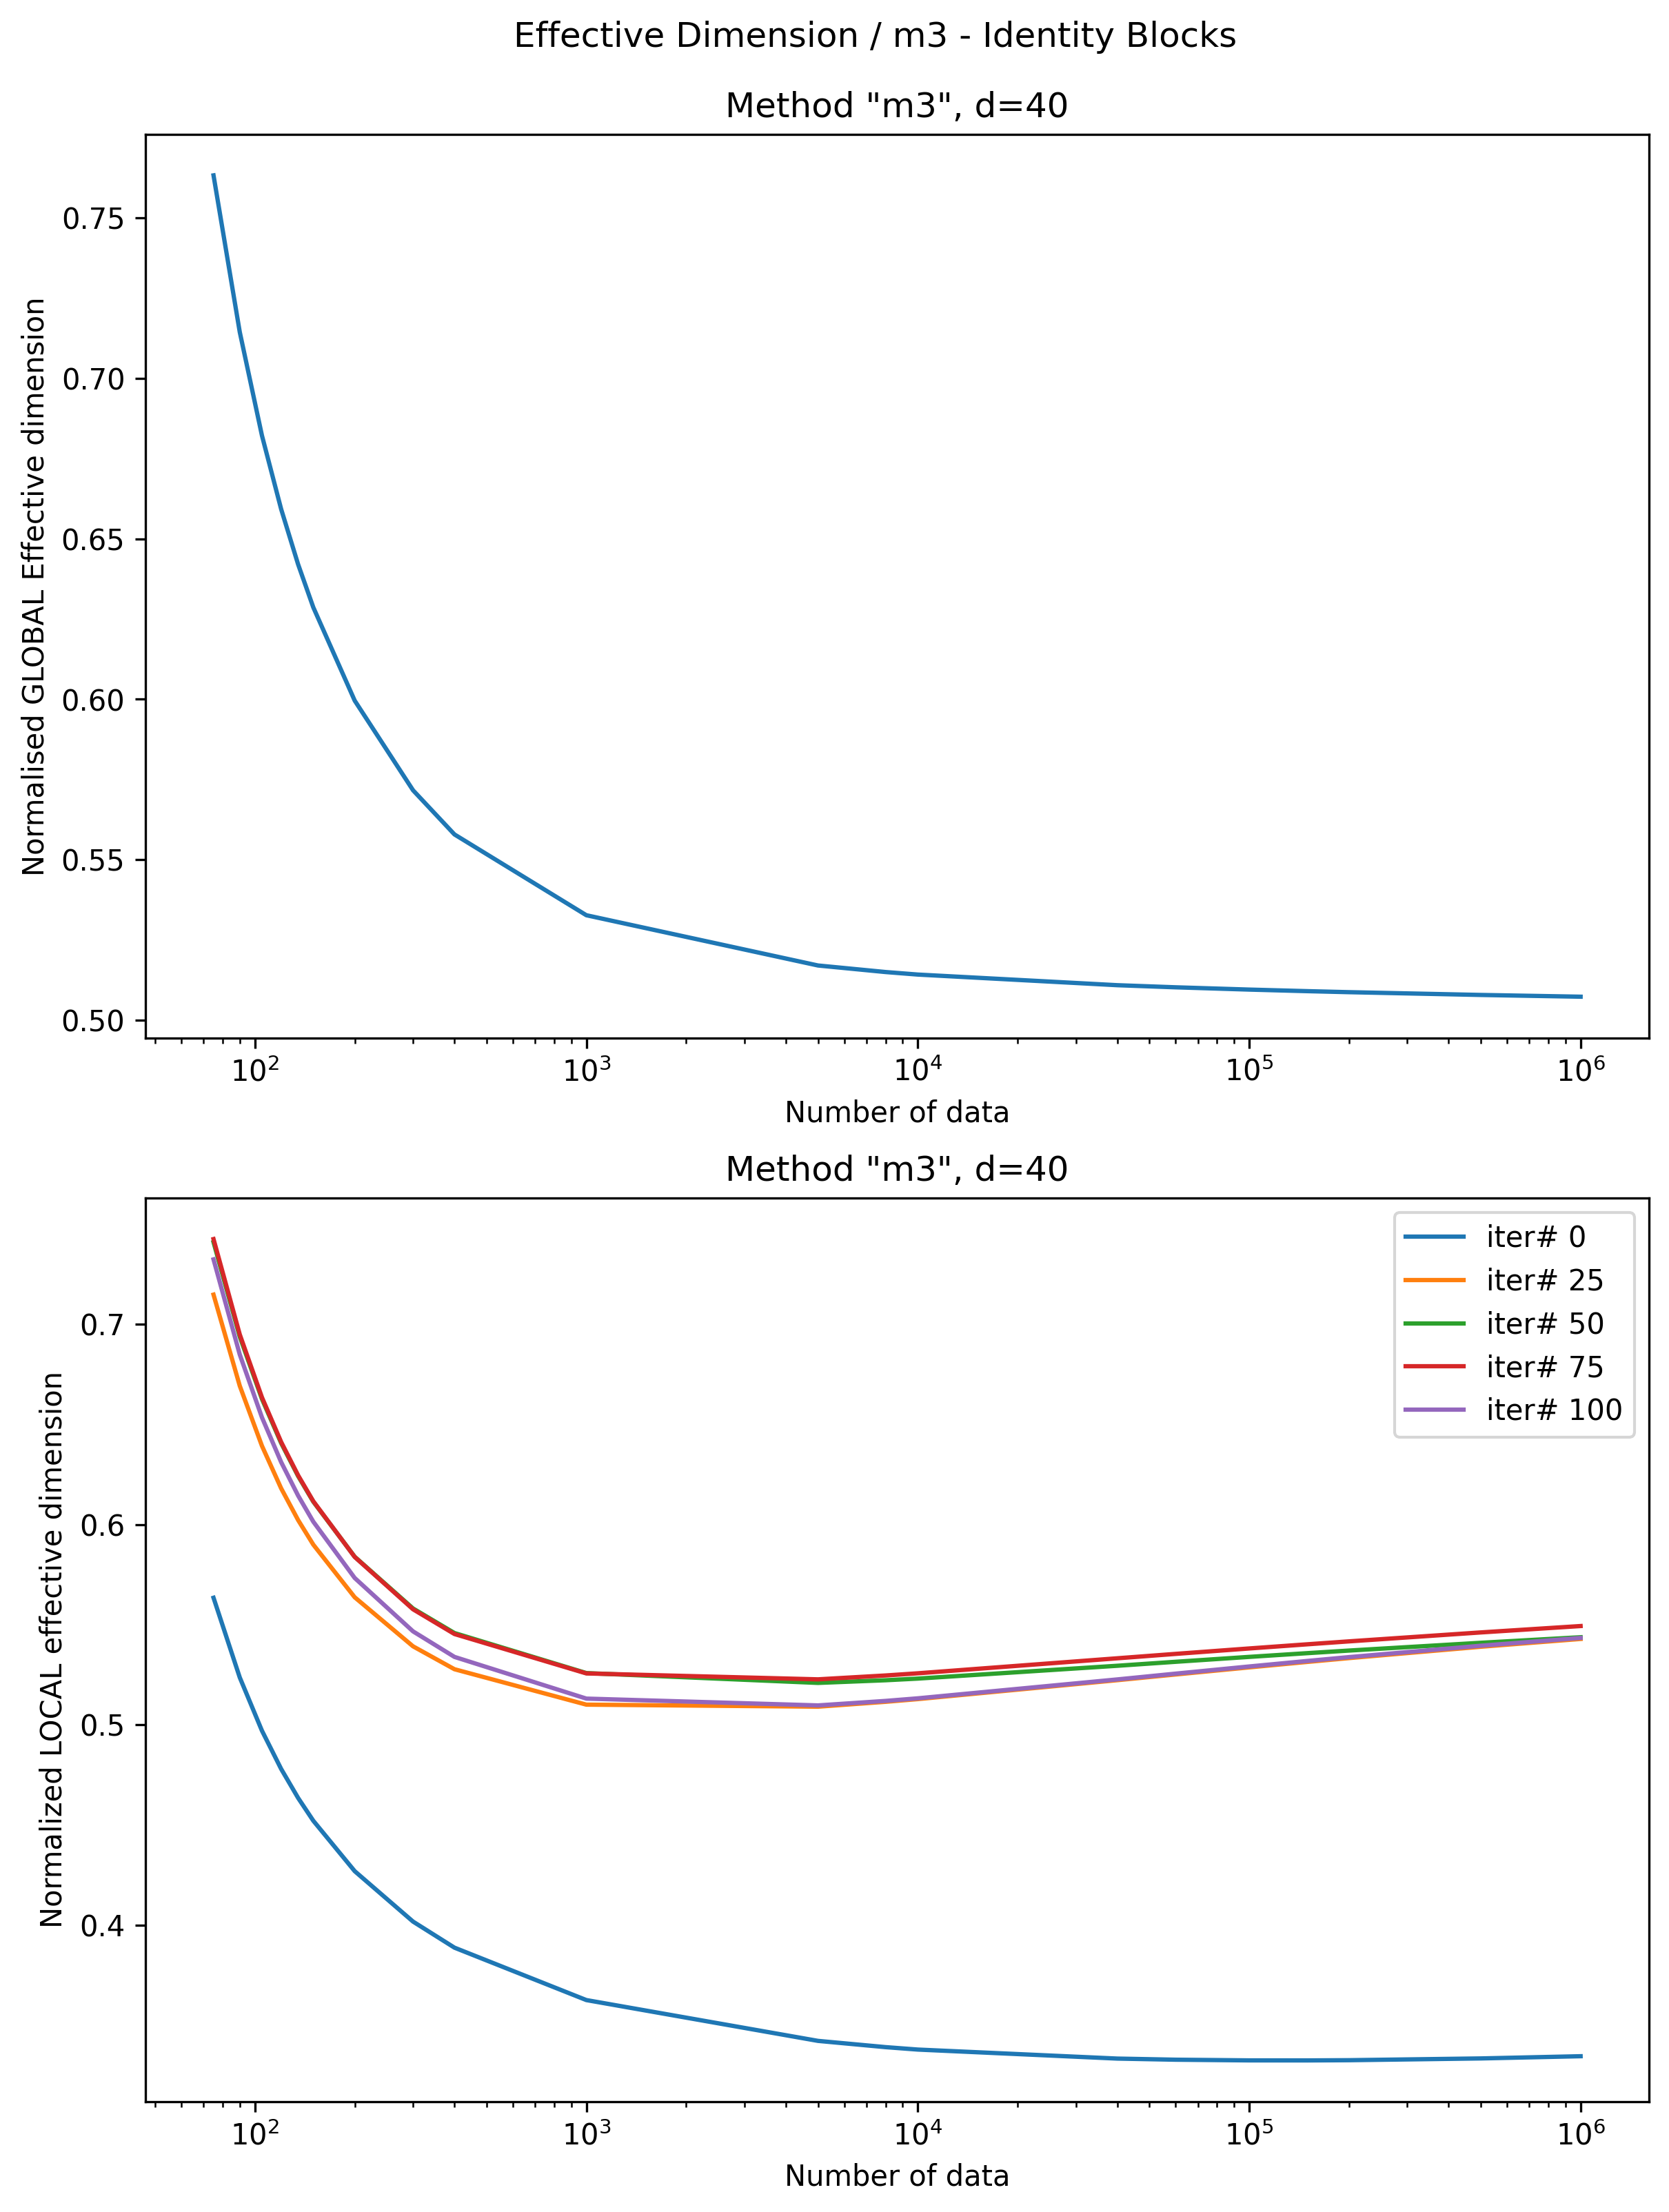

In [19]:
identity_block = preTrainedBlockGenerator(FEATURE_DIM, MAX_IDENTITIES_BLOCKS, overlay=2, entanglement=ENTANGLEMENT, insert_barriers=True)
ansatz = identity_block['circuit']

global_eff = calc_global_ed(FEATURE_DIM, reps, operator, n)
local_eff = calc_local_ed(FEATURE_DIM, reps, operator, n, 
                          weights[method], input_samples, ansatz=ansatz)
ed_plot(method, method_name, weights_no(weights[method]), ITER_STEP)

In [20]:
m = method
log_path = LOGS_PATH
df = pd.DataFrame(global_eff)

if (not exists(log_path)):
    print(f'Invalid archive: {log_path}')
else:
    if (not exists(f'{log_path}/{m}')):
        print(f'{" "*3}Missing method: {m}, creating the method')
        makedirs(f'{log_path}/{m}')
        
    df.to_csv(f'{log_path}/{m}/{m}-GlobalED.csv')
    for l in range(len(local_eff)):
        df = pd.DataFrame(local_eff[l])
        df.to_csv(f'{log_path}/{m}/{m}-{l}-LocalED.csv')

In [21]:
!pip list | grep qiskit

qiskit                        0.41.0
qiskit-aer                    0.11.2
qiskit-experiments            0.4.0
qiskit-finance                0.3.4
qiskit-ibm-experiment         0.2.8
qiskit-ibm-provider           0.2.1
qiskit-ibm-runtime            0.8.0
qiskit-ibmq-provider          0.20.0
qiskit-machine-learning       0.5.0
qiskit-nature                 0.5.2
qiskit-optimization           0.5.0
qiskit-terra                  0.23.1


In [22]:
!pip list | grep torch

torch                         1.13.1
torchaudio                    0.13.1
torchsummary                  1.5.1
torchvision                   0.14.1
